# Homework 8
## Sungwon Lee
### 017473950

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv("Google_Stock_Price_Train-1.csv")

In [3]:
print('number of rows and columns: ', df.shape)
df.head()

number of rows and columns:  (1258, 6)


,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [4]:
target = df[['Open']].values
scaler = MinMaxScaler(feature_range=(0,1))
target_scaled = scaler.fit_transform(target)

In [5]:
sequence_length = 60

def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(seq_length, len(data)):
        sequences.append(data[i-seq_length:i, 0])
        labels.append(data[i, 0])
    return np.array(sequences), np.array(labels)

X, y = create_sequences(target_scaled, sequence_length)

X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
y = torch.tensor(y, dtype=torch.float32)

In [6]:
train_size = int(len(X) * 0.8) # split
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Create data loaders
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


In [10]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x) 
        out = self.fc(out[:, -1, :])  
        return out

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
model = LSTM().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
# Training the model
num_epochs = 100
model.train()

for epoch in range(num_epochs):
    for sequences, labels in train_loader:
        sequences, labels = sequences.to(device), labels.to(device)

        outputs = model(sequences)
        loss = criterion(outputs.squeeze(), labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/100], Loss: 0.0374
Epoch [2/100], Loss: 0.0441
Epoch [3/100], Loss: 0.0213
Epoch [4/100], Loss: 0.0084
Epoch [5/100], Loss: 0.0030
Epoch [6/100], Loss: 0.0016
Epoch [7/100], Loss: 0.0017
Epoch [8/100], Loss: 0.0010
Epoch [9/100], Loss: 0.0011
Epoch [10/100], Loss: 0.0017
Epoch [11/100], Loss: 0.0016
Epoch [12/100], Loss: 0.0009
Epoch [13/100], Loss: 0.0009
Epoch [14/100], Loss: 0.0010
Epoch [15/100], Loss: 0.0012
Epoch [16/100], Loss: 0.0010
Epoch [17/100], Loss: 0.0009
Epoch [18/100], Loss: 0.0012
Epoch [19/100], Loss: 0.0013
Epoch [20/100], Loss: 0.0008
Epoch [21/100], Loss: 0.0006
Epoch [22/100], Loss: 0.0008
Epoch [23/100], Loss: 0.0006
Epoch [24/100], Loss: 0.0009
Epoch [25/100], Loss: 0.0006
Epoch [26/100], Loss: 0.0007
Epoch [27/100], Loss: 0.0006
Epoch [28/100], Loss: 0.0006
Epoch [29/100], Loss: 0.0012
Epoch [30/100], Loss: 0.0005
Epoch [31/100], Loss: 0.0006
Epoch [32/100], Loss: 0.0012
Epoch [33/100], Loss: 0.0002
Epoch [34/100], Loss: 0.0026
Epoch [35/100], Loss: 0

In [14]:
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for sequences, labels in test_loader:
        sequences, labels = sequences.to(device), labels.to(device)
        outputs = model(sequences)
        predictions.extend(outputs.squeeze().cpu().numpy())
        actuals.extend(labels.cpu().numpy())

# Rescale predictions back to the original scale
predictions_rescaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
actuals_rescaled = scaler.inverse_transform(np.array(actuals).reshape(-1, 1))

# Calculate RMSE
rmse = np.sqrt(np.mean((predictions_rescaled - actuals_rescaled) ** 2))
print(f'RMSE: {rmse:.2f}')


RMSE: 14.55


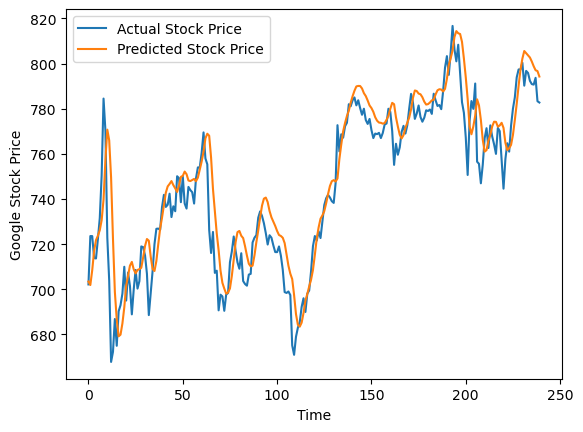

In [15]:
import matplotlib.pyplot as plt

plt.plot(actuals_rescaled, label="Actual Stock Price")
plt.plot(predictions_rescaled, label="Predicted Stock Price")
plt.xlabel("Time")
plt.ylabel("Google Stock Price")
plt.legend()
plt.show()
